# Investigating the $R_1$ and $R_2$ numbers introduced in Miyawaki 2022


In [34]:
import sys
import os
# REMOTE - So can access functions in isca_tools which is in home/Isca directory
# sys.path.append(os.path.join(os.environ['HOME'], 'Isca'))
# LOCAL - So can access functions in isca_tools which is in StAndrews/Isca
sys.path.append(os.environ['PWD'])
import isca_tools
from isca_tools.utils.moist_physics import lcl_temp, rh_from_sphum, saturation_vapor_pressure, mixing_ratio_from_sphum, dry_profile, moist_profile, mixing_ratio_from_partial_pressure, moist_static_energy, lapse_moist
from isca_tools.utils.radiation import frierson_net_toa_sw_dwn, frierson_sw_optical_depth, frierson_atmospheric_heating
from isca_tools.utils.constants import kappa, epsilon, L_v, c_p, g, R_v, radius_earth
from isca_tools.utils import area_weight_mean_lat, area_weighting, annual_mean
from isca_tools.papers.miyawaki_2022 import get_dmse_dt, get_dvmse_dy, get_r1
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import scipy.optimize
from tqdm import tqdm
from scipy import integrate
from scipy.interpolate import UnivariateSpline

In [3]:
exp_dir = 'tau_sweep/aquaplanet/'
var_keep = ['temp', 'sphum', 'height', 'vcomp', 'olr', 'swdn_toa', 'swdn_sfc', 'lwdn_sfc', 'lwup_sfc', 'flux_t', 'flux_lhe', 'ps']
tau_lw = 1
exp_dir = 'tau_sweep/aquaplanet/'
exp_name = f'k={tau_lw}'
ds = isca_tools.load_dataset(exp_dir + exp_name)[var_keep]
namelist = isca_tools.load_namelist(exp_dir + exp_name)  # Need this for albedo_value
albedo = namelist['mixed_layer_nml']['albedo_value']
tau_sw = namelist['two_stream_gray_rad_nml']['atm_abs']

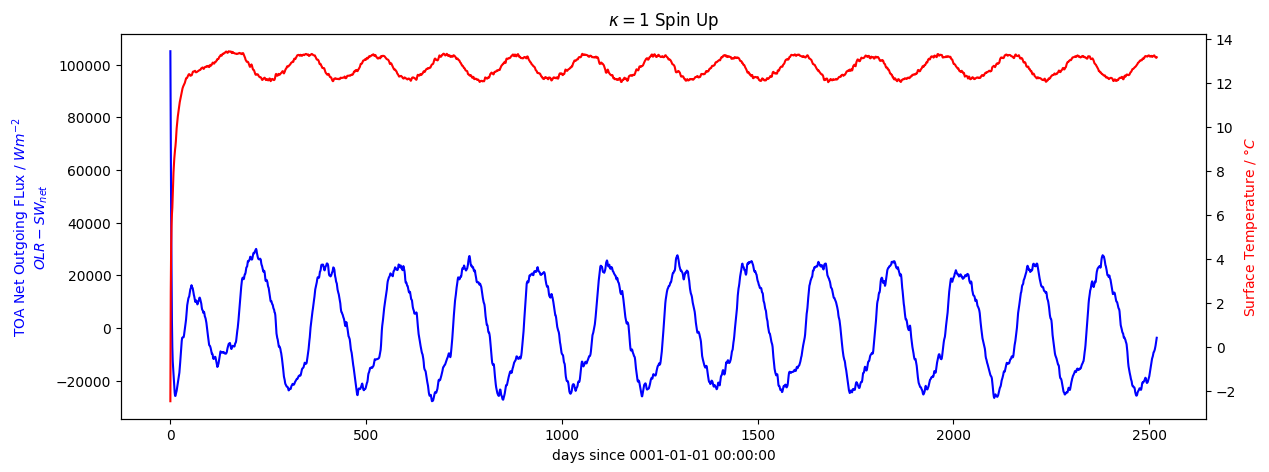

In [4]:
# Plot spin up time
fig, ax = plt.subplots(1,1, figsize=(14, 5))
isca_tools.plot.plot_spin_up(ds.olr, frierson_net_toa_sw_dwn(ds.swdn_toa, ds.ps, albedo, tau_sw),
                             ds.sel(pfull=np.inf, method="nearest").temp, ax)
plt.title(f'$\kappa = {tau_lw}$ Spin Up');

## Test Equation 1 first in the annual zonal mean
Do this so there is no $\partial_t m$ term.

In [5]:
# Use all data after 2 years, as clearly converged from the above spin up plot
use_time_start = 360*2
ds_use = ds.sel(time=slice(use_time_start, np.inf))

In [6]:
vm = (moist_static_energy(ds_use.temp, ds_use.sphum, ds_use.height)*1000 * ds_use.vcomp).mean(dim=['time', 'lon']).load()

The plot below shows what we expect i.e. MSE is transferred from the tropics to the poles, this then helps flatten out the temperature gradient.

In [7]:
vm_integ = np.asarray([integrate.simpson(vm[:,i]/g, ds.pfull*100) for i in range(ds.lat.size)])
# Fit a spline to work out the differential
cos_lat = np.asarray(np.cos(np.deg2rad(ds_use.lat)))
spl = UnivariateSpline(np.deg2rad(ds.lat), vm_integ/np.mean(np.abs(vm_integ)), s=0.2)
vm_integ_spline = spl(np.deg2rad(ds.lat)) * np.mean(np.abs(vm_integ))
vm_integ_div_spline = spl.derivative()(np.deg2rad(ds.lat)) * cos_lat/ (radius_earth * cos_lat) * np.mean(np.abs(vm_integ))
vm_integ_div = np.gradient(vm_integ * cos_lat, np.deg2rad(ds.lat))/ (radius_earth * cos_lat)

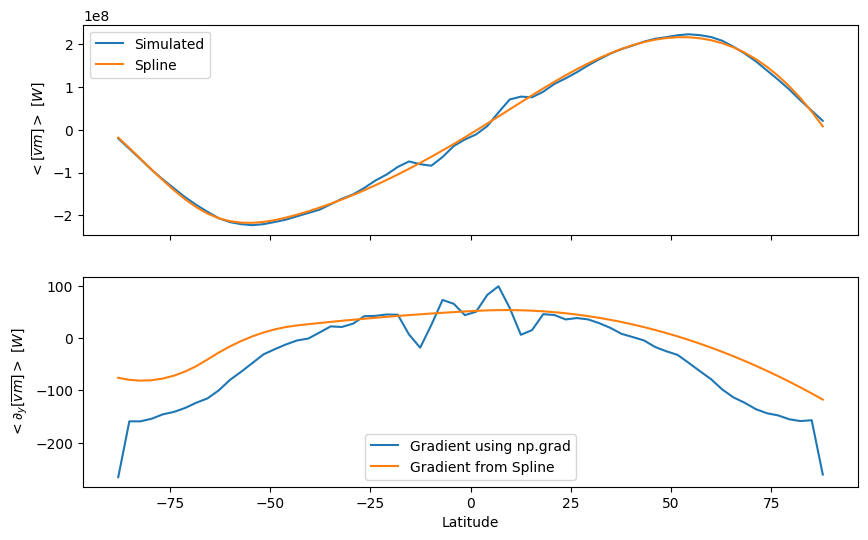

In [8]:
fig, ax = plt.subplots(2,1, figsize=(10, 6), sharex=True)
ax[0].plot(ds.lat, vm_integ, label='Simulated')
ax[0].plot(ds.lat, vm_integ_spline, label='Spline')
ax[1].plot(ds.lat, vm_integ_div, label='Gradient using np.grad')
ax[1].plot(ds.lat, vm_integ_div_spline, label='Gradient from Spline')
ax[1].set_xlabel('Latitude')
ax[0].set_ylabel('$<[\overline{vm}]>$ [$W$]')
ax[1].set_ylabel('$<\\partial_y [\overline{vm}]>$ [$W$]')
ax[0].legend()
ax[1].legend();

In [9]:
R_a_time_mean = frierson_atmospheric_heating(ds_use, albedo)
R_a_time_mean = R_a_time_mean.mean(dim=['lon', 'time'])

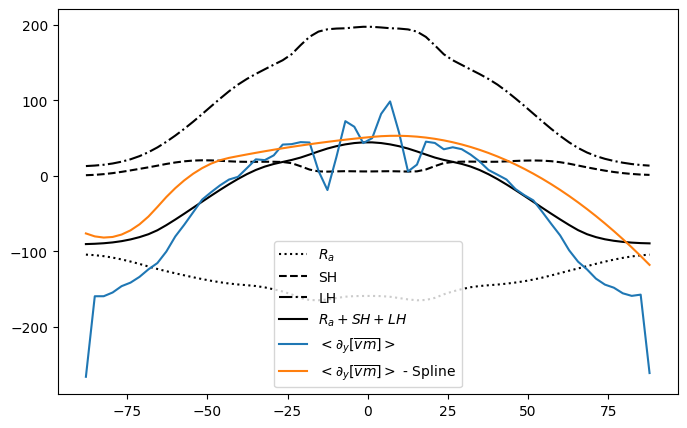

In [10]:
fig, ax = plt.subplots(1,1, figsize=(8, 5), sharex=True)
ax.plot(ds.lat, R_a_time_mean, label='$R_a$', color='k', linestyle=':')
ax.plot(ds.lat, ds_use.flux_t.mean(dim=['lon', 'time']), label='SH', color='k', linestyle='--')
ax.plot(ds.lat, ds_use.flux_lhe.mean(dim=['lon', 'time']), label='LH', color='k', linestyle='-.')
ax.plot(ds.lat, R_a_time_mean + ds_use.flux_t.mean(dim=['lon', 'time']) + ds_use.flux_lhe.mean(dim=['lon', 'time']),
        color='k', label='$R_a + SH + LH$')
ax.plot(ds.lat, vm_integ_div, label='$<\\partial_y [\overline{vm}]>$')
ax.plot(ds.lat, vm_integ_div_spline, label='$<\\partial_y [\overline{vm}]>$ - Spline')
ax.legend();

From the above plot, we see that the equation $<\partial_y [\overline{vm}]> = R_a + SH + LH$ is not exactly satisfied, but with the spline it does a pretty decent job.

This may be something to do how I integrated or differentiated e.g. not taking the correct pressure limits in the vertical integral. I think we expect convergence at bottom of atmosphere and divergence of MSE at top, so this may cause issues, if these don't cancel.

The blue line being bad at high latitudes is probably because you are dividing by $\cos(\phi)$ which is very small.

For actually getting the $R_1$ and $R_2$ values from now on, we infer $\partial_y(vm)$ from the residual as is done in the paper so equation 2 is always exactly satisfied.

### Sanity check of what `swdn_sfc` is
The plot below just shows that `swdn_sfc` is equal to the incident flux at the surface, ($e^{-\tau_{sw}} \times$ `swdn_toa`), which is equal to the flux incident at top of the atmosphere (`swdn_toa`) multiplied by the transmittance of the atmosphere ($e^{-\tau_{sw}}$).
The amount reflected by the surface ($\alpha \times$ incident flux) is then subtracted from this to give `swdn_sfc` = $(1-\alpha) e^{-\tau_{sw}} \times $ `swdn_toa`.

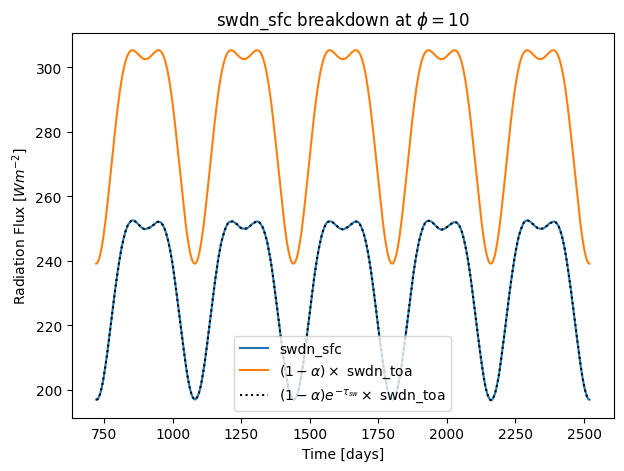

In [11]:
# Sanity check that swdn_sfc includes the albedo term
lat_plot = 10
fig, ax = plt.subplots(1,1, figsize=(7, 5))
ax.plot(ds_use.time, ds_use.sel(lat=10, method='nearest').swdn_sfc.mean(dim='lon'), label='swdn_sfc')
ax.plot(ds_use.time, (1-albedo)*ds_use.sel(lat=lat_plot, method='nearest').swdn_toa.mean(dim='lon'), label='$(1-\\alpha) \\times$ swdn_toa')
ax.plot(ds_use.time, (1-albedo)*ds_use.sel(lat=lat_plot, method='nearest').swdn_toa.mean(dim='lon')*
        np.exp(-frierson_sw_optical_depth(ds_use.sel(lat=lat_plot, method='nearest').mean(dim='lon').ps, tau_sw)),
        label='$(1-\\alpha) e^{-\\tau_{sw}} \\times $ swdn_toa', linestyle=':', color='k')
ax.set_ylabel('Radiation Flux [$Wm^{-2}$]')
ax.set_xlabel('Time [days]')
ax.set_title(f'swdn_sfc breakdown at $\phi={lat_plot}$')
ax.legend();

## Northern Mid-Latitudes and Northern High Latitudes Seasonal variation of $R_1$
Now we take the annual mean for two different latitude regions to see the variation of $R_1$ in each.

In [128]:
lat_min = [40, 80]
lat_max = [60, 90]
regions = ['NH Midlatitudes', 'NH High Latitudes']
n_regions = len(lat_min)
ds_region = []
with tqdm(total=n_regions, position=0, leave=True) as pbar:
    for i in range(n_regions):
        ds_region += [ds_use.where((ds_use.lat <= lat_max[i]) & (ds_use.lat >= lat_min[i]), drop=True)]
        ds_region[i] = area_weight_mean_lat(ds_region[i])
        ds_region[i] = annual_mean(ds_region[i]).load()
        pbar.update(1)

  0%|          | 0/2 [00:00<?, ?it/s]

Variables Averaged: ['temp', 'sphum', 'height', 'vcomp', 'olr', 'swdn_toa', 'swdn_sfc', 'lwdn_sfc', 'lwup_sfc', 'flux_t', 'flux_lhe', 'ps']


 50%|█████     | 1/2 [00:27<00:27, 27.73s/it]

Variables Averaged: ['temp', 'sphum', 'height', 'vcomp', 'olr', 'swdn_toa', 'swdn_sfc', 'lwdn_sfc', 'lwup_sfc', 'flux_t', 'flux_lhe', 'ps']


100%|██████████| 2/2 [00:52<00:00, 26.36s/it]


### $<[\partial_t m]>$ Computation
To compute $R_1$, we need to compute $<[\partial_t m]>$ first - we see how using a spline smooths this out below.

In [113]:
# zonal mean, vertically integrated MSE and its derivative
dt = 24 * 60**2
mse_integ = {'simulated': [0]*n_regions, 'spline': [0]*n_regions}
dm_dt = {'simulated': [0]*n_regions, 'spline': [0]*n_regions}
for i in range(n_regions):
    mse_integ['simulated'][i], dm_dt['simulated'][i] = get_dmse_dt(ds_region[i].temp, ds_region[i].sphum,
                                                                   ds_region[i].height, ds_region[i].pfull*100,ds_region[i].time*dt)
    mse_integ['spline'][i], dm_dt['spline'][i] = get_dmse_dt(ds_region[i].temp, ds_region[i].sphum, ds_region[i].height,
                                                             ds_region[i].pfull*100,ds_region[i].time*dt, spline_smoothing_factor=0.001)

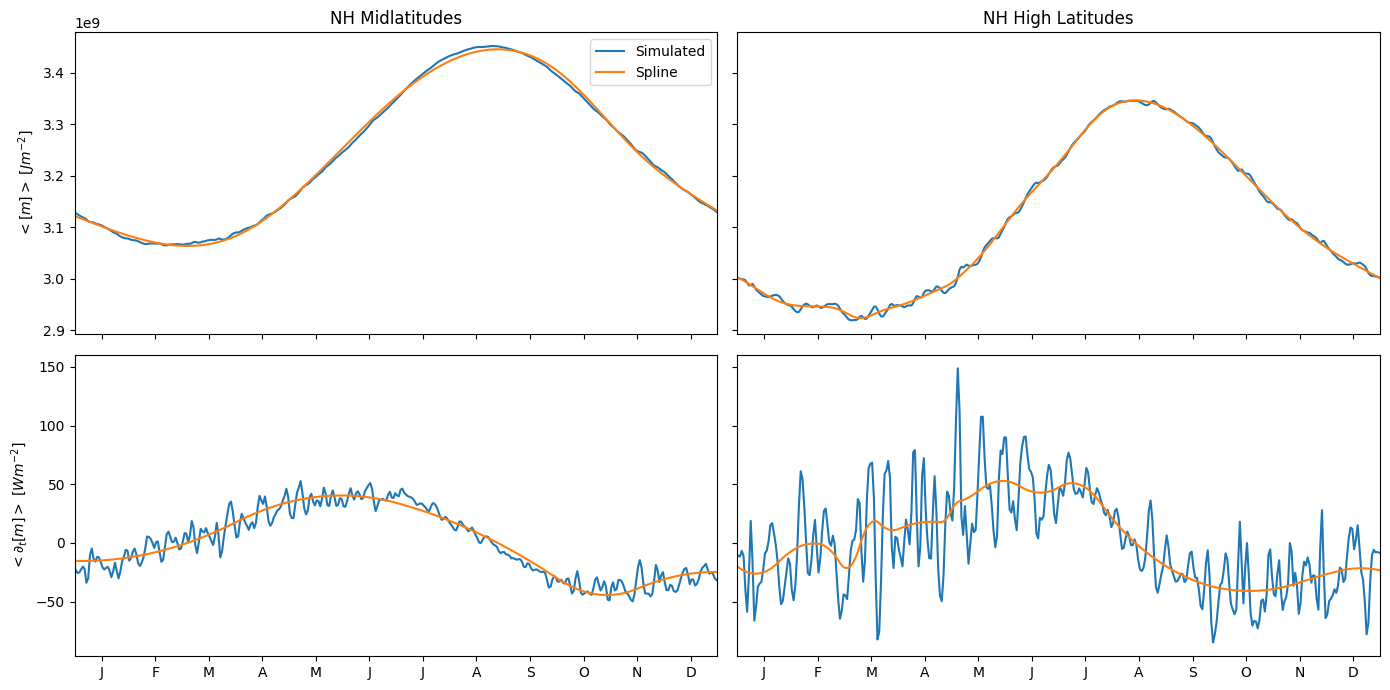

In [134]:
month_ticks = (np.arange(15,12*30+15,30), ['J','F','M','A','M','J','J','A','S','O','N','D'])

fig, ax = plt.subplots(2,n_regions, figsize=(14, 7), sharex=True, sharey='row')
for i in range(n_regions):
    ax[0,i].plot(ds_region[i].time, mse_integ['simulated'][i], label='Simulated')
    ax[0,i].plot(ds_region[i].time, mse_integ['spline'][i], label='Spline')
    ax[1,i].plot(ds_region[i].time, dm_dt['simulated'][i], label='Simulated')
    ax[1,i].plot(ds_region[i].time, dm_dt['spline'][i], label='Spline')
    ax[1, i].set_xticks(*month_ticks)
    ax[0, i].set_title(regions[i])
ax[0, 0].set_ylabel('$<[m]>$ [$Jm^{-2}$]')
ax[0, 0].legend()
ax[1, 0].set_ylabel('$<\\partial_t [m]>$ [$Wm^{-2}$]')
ax[0, 0].set_xlim(0,360)
plt.tight_layout();

### Figure 5b
Below we replicate figure 5b in the paper, to show the seasonality of the MSE budget in the different regions.

In [132]:
lh = [ds_region[i].flux_lhe.mean(dim=['lon']) for i in range(n_regions)]
sh = [ds_region[i].flux_t.mean(dim=['lon']) for i in range(n_regions)]
R_a = [frierson_atmospheric_heating(ds_region[i], albedo).mean(dim=['lon']) for i in range(n_regions)]
dvm_dy = [get_dvmse_dy(R_a[i], lh[i], sh[i], dm_dt['spline'][i]) for i in range(n_regions)]

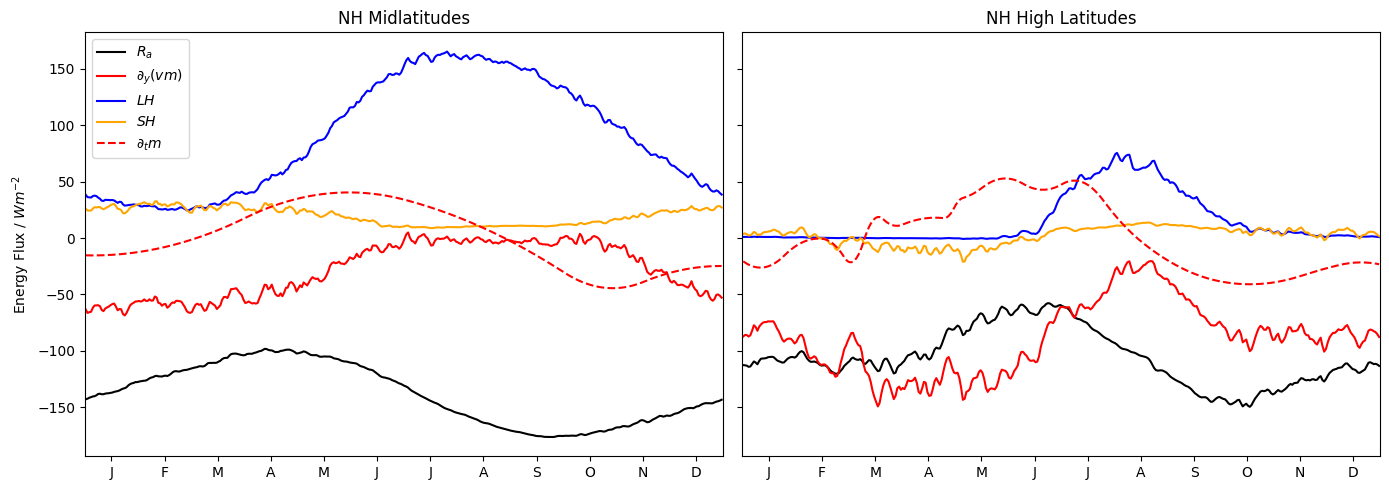

In [150]:
fig, ax = plt.subplots(1,n_regions, figsize=(14, 5), sharey=True, sharex=True)
for i in range(n_regions):
    ax[i].plot(ds_region[i].time, R_a[i], color='k', label='$R_a$')
    ax[i].plot(ds_region[i].time, dvm_dy[i], color='r', label='$\partial_y(vm)$')
    ax[i].plot(ds_region[i].time, lh[i], color='b', label='$LH$')
    ax[i].plot(ds_region[i].time, sh[i], color='orange', label='$SH$')
    ax[i].plot(ds_region[i].time, dm_dt['spline'][i], color='r', linestyle='--', label='$\partial_t m$')
    ax[i].set_title(regions[i])
ax[0].legend()
ax[0].set_xticks(*month_ticks)
ax[0].set_ylabel('Energy Flux / $Wm^{-2}$')
ax[0].set_xlim(0,360)
plt.tight_layout();

### Figure 4
Now we show the seasonal variation of $R_1$ and the lapse rate in each region.

The first plot below is just to check if the fit found by the spline is reasonable.

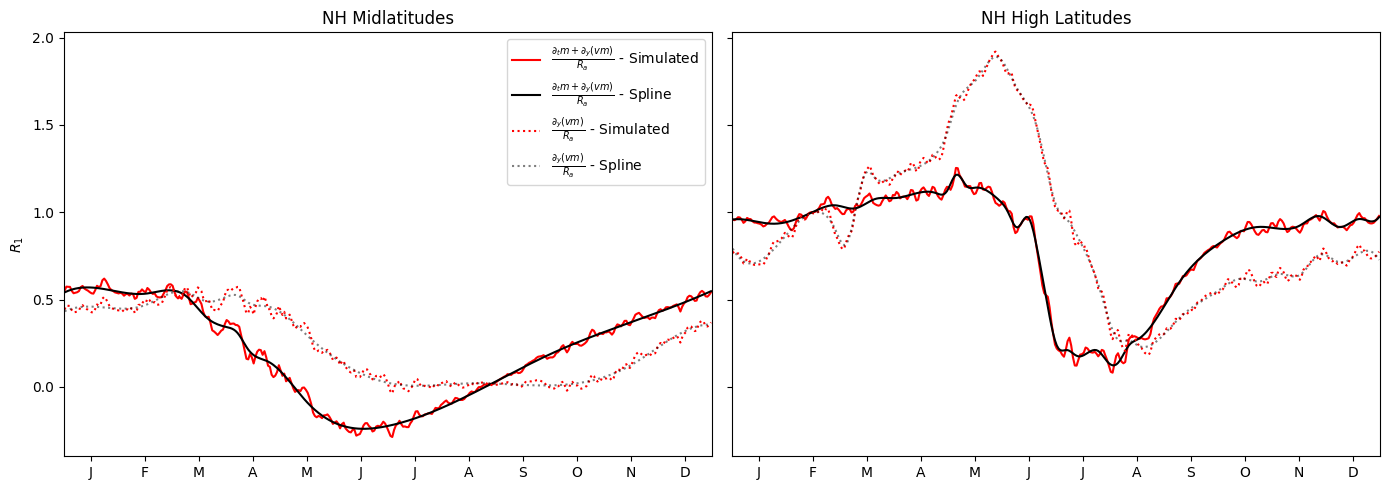

In [178]:
r1 = {'simulated': [get_r1(R_a[i], dm_dt['spline'][i], dvm_dy[i]) for i in range(n_regions)],
      'spline': [get_r1(R_a[i], dm_dt['spline'][i], dvm_dy[i], ds_region[i].time, 0.2) for i in range(n_regions)]}
r1_no_storage = {'simulated': [get_r1(R_a[i], dm_dt['spline'][i]*0, dvm_dy[i]) for i in range(n_regions)],
                 'spline': [get_r1(R_a[i], dm_dt['spline'][i]*0, dvm_dy[i], ds_region[i].time, 0.2) for i in range(n_regions)]}

fig, ax = plt.subplots(1,n_regions, figsize=(14, 5), sharey=True, sharex=True)
for i in range(n_regions):
    ax[i].plot(ds_region[i].time, r1['simulated'][i], color='r', label='$\\frac{\partial_t m + \partial_y(vm)}{R_a}$ - Simulated')
    ax[i].plot(ds_region[i].time, r1['spline'][i], color='k', label='$\\frac{\partial_t m + \partial_y(vm)}{R_a}$ - Spline')
    ax[i].plot(ds_region[i].time, r1_no_storage['simulated'][i], color='r', linestyle=':',
               label='$\\frac{\partial_y(vm)}{R_a}$ - Simulated')
    ax[i].plot(ds_region[i].time, r1_no_storage['spline'][i], color='k', linestyle=':', alpha=0.5,
               label='$\\frac{\partial_y(vm)}{R_a}$ - Spline')
    ax[i].set_title(regions[i])
ax[0].legend()
ax[0].set_xticks(*month_ticks)
ax[0].set_ylabel('$R_1$')
ax[0].set_xlim(0,360)
plt.tight_layout();

In [157]:
# Compute lapse rate deviation from moist adiabat averaged over specific sigma levels
sigma = ds.pfull/ds.pfull[-1]
# only use sigma levels specified in the paper - different for each region
sigma_min = [0.3, 0.9]
sigma_max = [0.7, 1]
use_sigma = [np.logical_and(sigma>=sigma_min[i], sigma<=sigma_max[i]).to_numpy() for i in range(n_regions)]
# Compute lapse rate in pressure coordinates i.e. dT/dp as can do using single line using np.gradient because pfull is the same for all
# times and longitudes.
lapse_actual_array = [np.gradient(ds_region[i].temp, ds_region[i].pfull*100, axis=1)[:, use_sigma[i]]
                      for i in range(n_regions)]
lapse_moist_array = [lapse_moist(ds_region[i].temp, ds_region[i].pfull*100, pressure_coords=True)[:, use_sigma[i]]
                     for i in range(n_regions)]
lapse_dev = [100*(lapse_moist_array[i] - lapse_actual_array[i])/lapse_moist_array[i] for i in range(n_regions)]
# #Proper way to compute lapse rate but takes longer as have to iterate over time and longitudes
# lapse_moist_array = lapse_moist(ds_single_lat.temp, ds_single_lat.pfull*100)[:, use_sigma]
# lapse_actual_array = np.zeros(lapse_moist_array.shape)
# with tqdm(total=lapse_actual_array.shape[0]*lapse_actual_array.shape[2], position=0, leave=True) as pbar:
#     for i in range(lapse_actual_array.shape[0]):
#         for j in range(lapse_actual_array.shape[2]):
#             lapse_actual_array[i, :, j] = -np.gradient(ds_single_lat.temp[i,:,j], ds_single_lat.height[i,:,j])[use_sigma]
#             pbar.update(1)

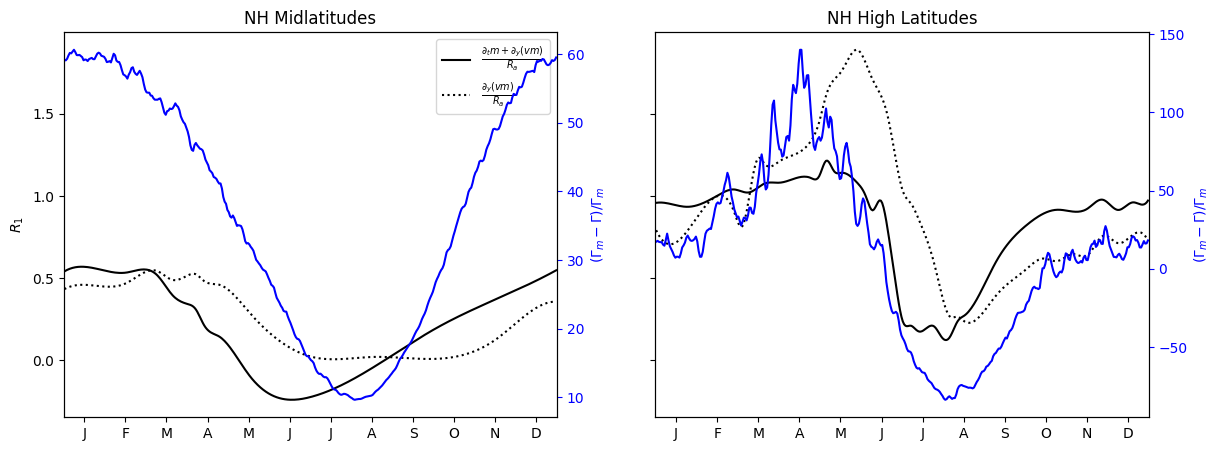

In [183]:
fig, ax = plt.subplots(1,n_regions, figsize=(14, 5), sharey=True, sharex=True)
for i in range(n_regions):
    ax[i].plot(ds_region[i].time, r1['spline'][i], color='k', label='$\\frac{\partial_t m + \partial_y(vm)}{R_a}$')
    ax[i].plot(ds_region[i].time, r1_no_storage['spline'][i], color='k', linestyle=':',
               label='$\\frac{\partial_y(vm)}{R_a}$')
    ax2 = ax[i].twinx()
    ax2.plot(ds_region[i].time, lapse_dev[i].mean(axis=(1,2)), color='b')
    ax2.set_ylabel('$(\Gamma_m - \Gamma)/\Gamma_m$', color='b')
    ax2.tick_params(axis='y', colors='b')
    ax[i].set_title(regions[i])
ax[0].legend()
ax[0].set_xticks(*month_ticks)
ax[0].set_ylabel('$R_1$')
ax[0].set_xlim(0,360);